# Hidden Markov Models

## Generating data

In [82]:
import numpy as np
import matplotlib.pyplot as plt

In [83]:
#let's say we have only two hidden states
z_val = np.array([0,1])

prob = np.array([.5,.5])
A = np.array([[.98,.02],[.02,.98]]) #transition matrix
B_pars = np.array([[0,.5],[5,.5]])

150


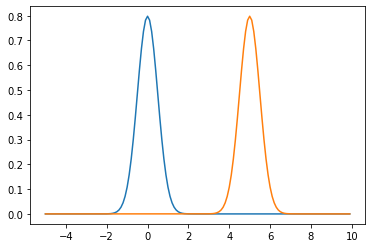

In [84]:
def gaussian(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-((x-mu)**2)/(2*sigma**2))

xt = np.arange(-5,10,.1)
y1=[]
y2=[]
for i in range(len(xt)):
    y1.append(gaussian(xt[i],B_pars[0][0], B_pars[0][1]))
    y2.append(gaussian(xt[i],B_pars[1][0], B_pars[1][1]))
    
plt.plot(xt,y1)
plt.plot(xt,y2)
print(len(xt))

In [85]:
def generate_initial_state(N, prob, B_pars):
    z = np.empty((N)) #hidden state sequence
    x = np.empty((N)) #observations
    
    #Generating first state and emission
    r = np.random.random()
    z[0] = np.where(r <= prob[0], 0, 1)
    x[0] = np.random.normal(loc=B_pars[0][0], scale=B_pars[0][1])

    return z, x

def generate_sequence(N, z, x, c, B_pars):
    for i in range(1, N):
        a = np.random.random()
        if z[i-1] == 0:
            z[i] = np.where(a <= c[0], 0, 1)
            x[i] = np.random.normal(loc=B_pars[0][0], scale=B_pars[0][1])
        else:
            z[i] = np.where(a <= c[1], 1, 0)
            x[i] = np.random.normal(loc=B_pars[1][0], scale=B_pars[1][1])
    return z, x


In [86]:
N = 100 #length of sequence
c = np.array([A[0,0],A[1,1]])# Transition probabilities

#generate the arrays z and x for the hidden state sequence and observations
z,x=generate_initial_state(N, prob, B_pars)
z,x=generate_sequence(N, z, x, c, B_pars)

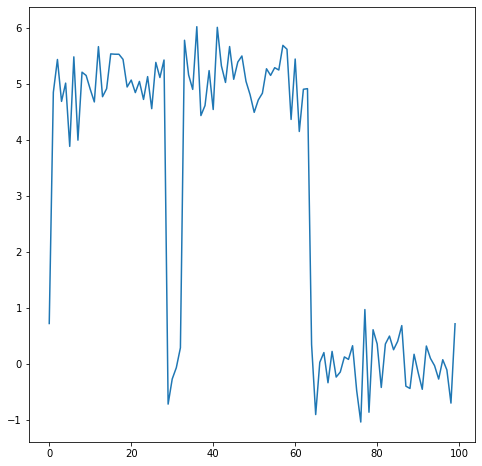

In [87]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(0,N,1),x[:N])

In [88]:
x_0 = x[np.where(z==0)]
print(x_0[:10])

[ 5.4205044  -0.72290504 -0.27412122 -0.07230975  4.90891229  0.340328
 -0.9092495   0.02353582  0.1974221  -0.341442  ]


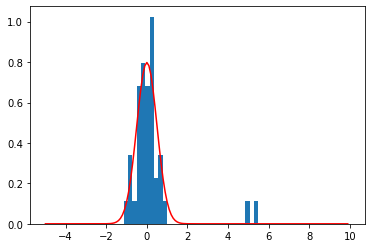

In [89]:
plt.hist(x_0, bins=70, range=(-5,10), density=True)
plt.plot(xt,y1,color='red')

In [90]:
#unique_0, counts_0 = np.unique(x_0, return_counts=True)

In [91]:
#plt.plot(unique_0,counts_0,'o')

In [92]:
x_0.mean()

0.2183419071774574

In [93]:
x_1 = x[np.where(z==1)]

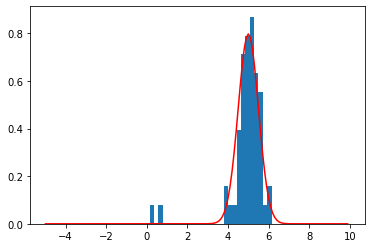

In [94]:
plt.hist(x_1, bins=70, range=(-5,10), density=True)
plt.plot(xt,y2,color='red')

In [95]:
#plt.plot(unique_1,counts_1,'o')

In [96]:
x_1.mean()

4.9126455286576824

# 1. EXPECTATION

## Forward and backward algorithm
The forward and backward algorithm are dynamic programming algorithms that compute the probability of observing a sequence of observations given an HMM. The forward algorithm works by computing the alpha values recursively using the initial probabilities, transition probabilities, and observation probabilities of the HMM. The backward algorithm proceeds in a similar way but it starts from the last time step, working backwards.

The alpha variable represents the probability of observing the first t observations and being in state i at time t:
\begin{equation}
\alpha_t(i) = P(x_{1:t}, z_t = i)
\end{equation}
where $x_{1:t}$ are the first t observations, $z_t$ is the state at time t.

The beta variable represents the probability of observing the remaining observations from time t+1 to the end, given that we are in state i at time t: 
\begin{equation}
\beta_t(i) = P(x_{t+1:T} | z_t = i)
\end{equation}
where $x_{t+1:T}$ are the remaining observations after time t.
The alpha and beta variable are typically computed recursively using the following formulas:

\begin{equation}
\alpha_{t}(j) = \sum_{i=1}^{N} \alpha_{t-1}(i) a_{ij} b_j(z_{t+1})
\end{equation}

\begin{equation}
\beta_t(i) = \sum_{j=1}^{N} a_{ij} b_j(x_{t+1}) \beta_{t+1}(j)
\end{equation}

where $N$ is the number of states in the HMM, $a_{ij}$ is the probability of transitioning from state i to state j, $b_j(x_{t+1})$ is the probability of observing the next observation $x_{t+1}$ given that we are in state j. The $\alpha_t(i)$ term is the alpha value for state i at time t and $\beta_{t+1}(j)$ is the beta value for state j at time $t+1$.

In [97]:
A = np.array([[.98,.02],[.02,.98]]) #transition matrix

def calculate_emission_matrix(B_pars, x):
    b = np.zeros((2, len(x)))# Create emission probability matrix b
    T=len(x)
    for i in range(T):
        b[0, i] = gaussian(x[i], B_pars[0][0], B_pars[0][1])
        b[1, i] = gaussian(x[i], B_pars[1][0], B_pars[1][1])
    return b


def forward_algorithm(x, A, b, pi=prob[0]):
    # x: observed sequence (array of shape (T,))
    # A: transition probability matrix (array of shape (2, 2))
    # b: emission probability matrix (array of shape (2, T))
    # pi: initial state distribution (array of shape (2,))
    # returns: alpha, the forward variable (array of shape (2, T))

    T = len(x)
    alpha = np.zeros((2, T))

    # initialization of the first alpha
    alpha[:, 0] = (pi * b[:, 0])
    
    # recursion
    for t in range(1, T):
        for j in range(2):
            alpha[j, t] = np.sum(alpha[:, t-1] * A[:, j]) * b[j, t]
        #alpha[:,t]=alpha[:, t]/np.sum(alpha[:,t])

    return alpha


def backward_algorithm(x, A, b):
    # x: observed sequence (array of shape (T,))
    # A: transition probability matrix (array of shape (2, 2))
    # b: emission probability matrix (array of shape (2, T))
    # returns: beta, the backward variable (array of shape (2, T))

    T = len(x)
    beta = np.zeros((2, T))

    # initialization of the last beta
    #we assume that in the HMM the probability of observing the last observation given any state at time T is 1
    #Here -1 index represents the last column of the matrix, regardless of the total number of columns
    beta[:, -1] = 1

    # recursion
    for t in range(T-2, -1, -1):
        for j in range(2):
            beta[j, t] = np.sum(beta[:, t+1]*A[j, :]*b[:, t+1])
        #beta[:,t]=beta[:, t]/np.sum(beta[:,t])

    return beta

In [98]:
b=calculate_emission_matrix(B_pars, x)
alphas=forward_algorithm(x, A, b, pi=prob[0])
betas =backward_algorithm(x, A, b)

In [99]:
print(z)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [100]:
print(alphas)

[[1.42949600e-01 4.67981314e-22 8.54238415e-31 1.71512940e-24
  1.97176246e-27 8.01446754e-19 5.24324889e-33 4.40605665e-21
  9.17189133e-32 2.20205716e-31 2.30499300e-29 1.35255541e-27
  1.18447156e-36 4.80497425e-29 2.11173715e-30 3.80205707e-36
  1.92464956e-36 8.85289652e-37 2.94872066e-36 4.37397610e-32
  2.87611822e-33 1.87434010e-31 2.70360388e-33 1.11277957e-30
  2.45499696e-34 1.20472424e-29 4.71102057e-37 7.98068345e-35
  8.39583069e-38 5.37639681e-13 3.61734185e-13 2.79907218e-13
  1.86500554e-13 1.65056729e-42 1.21627303e-40 1.62835020e-38
  3.05662067e-49 7.51766547e-36 1.21340647e-37 3.25844172e-43
  1.77519707e-37 3.34484175e-51 2.02354476e-45 5.91548521e-43
  5.25143153e-49 4.81956549e-44 6.00526012e-47 3.28275233e-48
  2.18133190e-44 1.90952499e-42 4.69412469e-40 3.68111840e-42
  2.46170422e-43 2.70503382e-47 2.17051146e-46 9.21078778e-48
  1.45788182e-47 6.83762923e-52 1.01322905e-51 2.65781517e-41
  6.10003687e-51 1.88230964e-40 4.12053191e-47 2.54930231e-47
  1.3259

### Avoiding overflow

To avoid overflow in the calculations of gamma and beta, we can rewrite them as exponentials ($\alpha = e^{l}$) and compute $l$ instead; in this way, all the products turn into sums and the algorithm is robust against overflow even for larger N.

In [101]:
def forward_opt(x, A, b, pi=prob):
    T = len(x)
    alpha = np.zeros((2,T))
    l = np.zeros((2,T))

    alpha[:, 0] = pi[:] * b[:, 0]
    l[0,0] = np.log(alpha[0,0])
    l[1,0] = np.log(alpha[1,0])

    y = np.zeros((2))
    for t in range(1, T):
        for j in range(2):
            y[0] = np.log(b[j,t])+np.log(A[0,j])+l[0,t-1]
            y[1] = np.log(b[j,t])+np.log(A[1,j])+l[1,t-1]
            l[j,t] = np.log(np.exp(y[0])+np.exp(y[1]))
            ymax = y.max()
            l[j,t] = ymax+np.log(np.exp(y[0]-ymax)+np.exp(y[1]-ymax))
            
            alpha[j,t] = np.exp(l[j,t])
        #alpha[:,t]=alpha[:, t]/np.sum(alpha[:,t])
    return alpha

In [103]:
b=calculate_emission_matrix(B_pars, x)
alphas=forward_algorithm(x, A, b, pi=prob)
alphas_opt = forward_opt(x,A,b,prob)

In [104]:
print('Alphas calculate directly: \n')
print(alphas[:,40:50], '\n\n')
print('Alphas with log-sum-exp trick: \n')
print(alphas_opt[:,40:50],)

Alphas calculate directly: 

[[1.77519707e-37 3.34484175e-51 2.02354476e-45 5.91548521e-43
  5.25143153e-49 4.81956549e-44 6.00526012e-47 3.28275233e-48
  2.18133190e-44 1.90952499e-42]
 [4.28050862e-18 4.45909671e-19 2.85551766e-19 2.23106368e-19
  7.28931420e-20 5.63370532e-20 3.28164859e-20 1.57983168e-20
  1.23138167e-20 8.88835552e-21]] 


Alphas with log-sum-exp trick: 

[[1.77519707e-37 3.34484175e-51 2.02354476e-45 5.91548521e-43
  5.25143153e-49 4.81956549e-44 6.00526012e-47 3.28275233e-48
  2.18133190e-44 1.90952499e-42]
 [4.28050862e-18 4.45909671e-19 2.85551766e-19 2.23106368e-19
  7.28931420e-20 5.63370532e-20 3.28164859e-20 1.57983168e-20
  1.23138167e-20 8.88835552e-21]]


In [105]:
def backward_opt(x, A, b):
    T = len(x)
    beta = np.zeros((2,T))
    l = np.zeros((2,T))

    beta[:, -1] = 1
    l[0,-1] = np.log(beta[0,-1])
    l[1,-1] = np.log(beta[1,-1])

    y = np.zeros((2))
    for t in range(T-2, -1, -1):
        for j in range(2):
            y[0] = np.log(b[0,t+1])+np.log(A[j,0])+l[0,t+1]
            y[1] = np.log(b[1,t+1])+np.log(A[j,1])+l[1,t+1]
            ymax = y.max()
            l[j,t] = ymax+np.log(np.exp(y[0]-ymax)+np.exp(y[1]-ymax))
            
            beta[j,t] = np.exp(l[j,t])
       
        #beta[:,t]=beta[:, t]/np.sum(beta[:,t])
    return beta

In [106]:
b = calculate_emission_matrix(B_pars, x)
betas = backward_algorithm(x, A, b)
betas_opt = backward_opt(x,A,b)

In [107]:
print('betas calculate directly: \n')
print(betas[:,40:50], '\n\n')
print('betas with log-sum-exp trick: \n')
print(betas_opt[:,40:50],)

betas calculate directly: 

[[2.01972413e-21 1.93883360e-20 3.02762845e-20 3.87503351e-20
  1.18604388e-19 1.53459331e-19 2.63448272e-19 5.47238458e-19
  7.02093161e-19 9.72671098e-19]
 [9.89664821e-20 9.50028464e-19 1.48353794e-18 1.89876642e-18
  5.81161503e-18 7.51950724e-18 1.29089653e-17 2.68146845e-17
  3.44025649e-17 4.76608838e-17]] 


betas with log-sum-exp trick: 

[[2.01972413e-21 1.93883360e-20 3.02762845e-20 3.87503351e-20
  1.18604388e-19 1.53459331e-19 2.63448272e-19 5.47238458e-19
  7.02093161e-19 9.72671098e-19]
 [9.89664821e-20 9.50028464e-19 1.48353794e-18 1.89876642e-18
  5.81161503e-18 7.51950724e-18 1.29089653e-17 2.68146845e-17
  3.44025649e-17 4.76608838e-17]]


### Probability
we now can compute $p(z_t|x)=\alpha_t*\beta_t$

In [108]:
#conditional probability of having a certain hidden value at time t: alpha(0,t)*beta(0,t) or alpha(1,t)*beta(1,t)
#define an array of probabilities p(2,N): to each column corresponds the probability of having, respectively, z=0 or z=1
p_zx = np.zeros((2,N))
for t in range(N):
    p_zx[0,t]=(alphas_opt[0,t]*betas_opt[0,t])
    p_zx[1,t]=(alphas_opt[1,t]*betas_opt[1,t])
    #normalizing:
    p_zx[:,t]=p_zx[:,t]/np.sum(p_zx[:,t])

#Here we define the most probable sequence, this is just to check if it works but shouldn't be done in the training
z_exp = np.zeros((N,))
for t in range(N):
    r = np.random.random()
    if r<=p_zx[0,t]:
        z_exp[t]=0
    elif r<=p_zx[0,t]+p_zx[1,t]:
        z_exp[t]=1
        
        
check = np.full((N,),False)
for i in range(N):
    if z_exp[i]==z[i]:
        check[i]='True'
check

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# 2. MAXIMIZATION

## Gamma and Psi

\begin{equation}
\gamma_t(i) = \frac{\alpha_t(i)\beta_t(i)}{\sum_{j=1}^{N}\alpha_t(j)\beta_t(j)}
\end{equation}

where $N$ is the number of states in the HMM, $\alpha_t(i)$ is computed at time $t$ and state $i$, and $\beta_t(i)$ is computed at time $t$ and state $i$. This formula computes the probability of being in state $i$ at time $t$, given the observed sequence and the HMM parameters.

The formula for the psi value at time step $t$, current state $i$, and next state $j$ is:

\begin{equation}
\psi_t(i,j) = \frac{\alpha_t(i)a_{ij}b_j(x_{t+1})\beta_{t+1}(j)}{\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_t(i)a_{ij}b_j(x_{t+1})\beta_{t+1}(j)}
\end{equation}

where $N$ is the number of states in the HMM, $a_{ij}$ is the transition probability from state $i$ to state $j$, $b_j(x_{t+1})$ is the emission probability of the observation $x_{t+1}$ given state $j$, and $\beta_{t+1}(j)$ is the backward variable at time $t+1$ and state $j$. 

In [109]:
#gamma[0][i] = alpha[0][i]*beta[0][i]/(alpha[0][i]*beta[0][i]+alpha[1][i]*beta[1][i] )
#gamma[1][i] =  alpha[1][i]*beta[1][i]/(alpha[0][i]*beta[0][i]+alpha[1][i]*beta[1][i] )
  
def get_gamma(x, alpha, beta):
    n = alpha.shape[0]  # number of states
    T = len(x)
    gamma = np.zeros((n, T))

    for t in range(T):
        norm = np.sum(alpha[:, t] * beta[:, t]) #dot product
        for i in range(n):
            gamma[i, t] = (alpha[i, t] * beta[i, t]) / norm

    return gamma


#This is how calculate_psi was calculated before the modification

#def calculate_psi(t, i, j, alpha, beta, A, b):
#    denom = alpha[j][t] * beta[j][t] * A[j][i] * b[i][t+1]
#    return (alpha[i][t] * A[i][j] * beta[j][t+1] * b[j][t+1]) / denom

#This is what i modified: 
# Changed the order to compare better with the formula 
# Changed the index t of beta
# Changed how the denominator is deined
def calculate_psi(t, i, j, alpha, beta, A, b):
    
    #numerator
    num = alpha[i][t] * A[i][j] * b[j][t+1]* beta[j][t+1]

    #compute denominator
    denom=0
    for a in range(alpha.shape[0]):
        denom+=alpha[a][t]*np.sum(A[a,:] * b[:,t+1]* beta[:,t+1])
    
    return num/denom

def get_psi(x, beta, alpha, A, b):
    n = alpha.shape[0]  # number of states
    psi = np.zeros((n, n, len(x)))
    for t in range(1, len(x)-1):
        for j in range(n):  # z_t = j
            for i in range(n):  # z_t+1 = i
                psi[i][j][t] = calculate_psi(t, i, j, alpha, beta, A, b)
    return psi
 

## Update: $\pi_i,a_{ij},b_i(x)$

## - $\pi_i$

In [110]:
def update_pi(K, N, prob, B_pars, A, c):
    K = 10
    N = 100 #(timesteps)
    prob_up = np.zeros((2,))
    gamma_k = np.zeros((2,K))

    for k in range(K):  
        z,x = generate_initial_state(N, prob, B_pars)
        z,x = generate_sequence(N, z, x, c, B_pars)
        #print(z[0])

        b = calculate_emission_matrix(B_pars, x)
        alphas_opt = forward_opt(x,A,b,prob)
        betas_opt = backward_opt(x,A,b)

        gamma = get_gamma(x, alphas_opt, betas_opt)
        gamma_k[0,k] = gamma[0,1] #getting the first value of the sequence of gamma for z=0
        gamma_k[1,k] = gamma[1,1] #getting the first value of the sequence of gamma for z=1  (should be gamma[1,0])
                                                                                             #but it doesn't work

    prob_up[0] = np.sum(gamma_k[0,:])/K
    prob_up[1] = np.sum(gamma_k[1,:])/K

    return prob_up
    
#Why does it not work for gamma[0,0] but for gamma[0,1]?

In [111]:
K = 10
N = 100
update_pi(K, N, prob, B_pars, A, c)

array([0.5, 0.5])

## - $a_{ij}$

In [112]:
def update_a(N,psi, prob, B_pars, c, A):
    N = 100
    A_up = np.zeros((2,2))
    norm = np.zeros((N,))
    np.random.seed(1234)

    #z,x = generate_initial_state(N, prob, B_pars)
    #z,x = generate_sequence(N, z, x, c, B_pars)
    #b = calculate_emission_matrix(B_pars, x)
    #alphas_opt = forward_opt(x,A,b,prob)
    #betas_opt = backward_opt(x,A,b)

    #psi=get_psi(x, betas_opt, alphas_opt, A, b)

    for i in range(2):      #hidden states
        norm[i] = np.sum(psi[i,:,:])
        for j in range(2):
            A_up[i,j] = np.sum(psi[i,j,:])


    for i in range(2):      #hidden states
        for j in range(2):            
            A_up[i,j] = A_up[i,j]/(norm[i])
            #print(np.sum(A_up[i,:])/norm[i])

    return A_up


## - $b_i(x)$


In [79]:
def update_b(N,gamma, prob, B_pars, c,x):
    N = 100
    B_pars_up = np.zeros((2,2))
    np.random.seed(1234)

    #z,x = generate_initial_state(N, prob, B_pars)
    #z,x = generate_sequence(N, z, x, c, B_pars)
    #b = calculate_emission_matrix(B_pars, x)
    #alphas_opt = forward_opt(x,A,b,prob)
    #betas_opt = backward_opt(x,A,b)

    #gamma = get_gamma(x, alphas_opt, betas_opt)
    x_mu = np.zeros((2,N))

    for i in range(2):
        #update mus (mean of gaussians)
        B_pars_up[i,0]= np.sum(gamma[i,:]*x)/np.sum(gamma[i,:])  #sum over all t

        #update sigmas of gaussians
        x_mu[i,:] = x-B_pars[i,0] #x-mu_0, x-mu_1
        B_pars_up[0,1]= np.sum(gamma[0,:]*np.outer(x_mu[1,:],x_mu[0,:]))/np.sum(gamma[0,:])  #sum over all t

        #Before modification
        #B_pars_up[1,1]= np.sum(gamma[0,:]*np.outer(x_mu[0,:].T,x_mu[1,:]))/np.sum(gamma[1,:])

        #After changing the index in gamma
        B_pars_up[1,1]= np.sum(gamma[1,:]*np.outer(x_mu[0,:].T,x_mu[1,:]))/np.sum(gamma[1,:])  #sum over all t

    return (B_pars_up, x_mu)

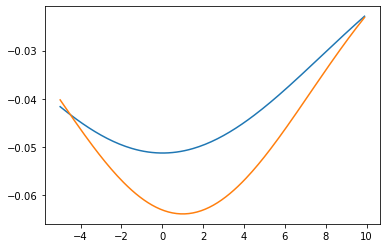

In [67]:
xt = np.arange(-5,10,.1)
y1=[]
y2=[]
for i in range(len(xt)):
    y1.append(gaussian(xt[i],B_pars_up[0][0], B_pars_up[0][1]))
    y2.append(gaussian(xt[i],B_pars_up[1][0], B_pars_up[1][1]))
    
plt.plot(xt,y1)
plt.plot(xt,y2)

# Training the model
Given the functions for expectation, maximization, backward, and forward, which have already been defined, a training function for a Hidden Markov Model can be written. This training function sequentially repeats the expectation-maximization algorithm until convergence is reached, defined as the point at which the parameter updates in maximization (i.e., pi, a, and b) do not change substantially

In [115]:
def training(x,A,b,c, prob, B_pars, N, K, n_iter=10000, tol=1e-6):
    
    # Initialize model parameters
    pi_ = prob
    a_ = A
    b_ = B_pars
    
    # Initialize convergence criterion
    diff_pi = 0
    diff_a = 0
    diff_b = 0
    
    #initial step of expectation
    b=calculate_emission_matrix(B_pars, x) 
    alpha = forward_opt(x,A,b,prob)
    beta = backward_opt(x,A,b)
    gamma=get_gamma(x, alpha, beta)
    psi=get_psi(x, beta, alpha, A, b)
        
  # Iterate expectation-maximization algorithm until convergence
    for i in range(n_iter):
        
        # Maximization step
        pi_new = update_pi(K, N, pi_, b_, a_, c)
        a_new =  update_a(N,psi, pi_, b_, c, a_)
        b_new,_ =  update_b(N,gamma, pi_, b_, c,x)
        
        # Expectation step
        b=calculate_emission_matrix(b_new, x) 
        alpha = forward_opt(x, a_new, b, pi_new)
        beta = backward_opt(x, a_new, b)
        gamma=get_gamma(x, alpha, beta)
        psi=get_psi(x, beta, alpha, a_new, b) 
    
        # Check convergence
        diff_pi = sum(abs(pi_new - pi_))
        diff_a = sum(abs(a_new - a_))
        diff_b = sum(abs(b_new - b_))

        #if (diff_pi < tol).all() and (diff_a < tol).all() and (diff_b < tol).all():
            #break

        # Update parameters
        pi_ = pi_new
        a_ = a_new
        b_ = b_new
 
  
  # Return trained model parameters
    return {'pi': pi_, 'a': a_, 'b': b_, 'i':i}

In [116]:
K=10
N=100
training(x,A,b,c, prob, B_pars, N, K, n_iter=100, tol=1e-6)

/tmp/ipykernel_14155/2688107866.py:15: RuntimeWarning: divide by zero encountered in log
  l[j,t] = np.log(np.exp(y[0])+np.exp(y[1]))
/tmp/ipykernel_14155/2688107866.py:13: RuntimeWarning: divide by zero encountered in log
  y[0] = np.log(b[j,t])+np.log(A[0,j])+l[0,t-1]
/tmp/ipykernel_14155/2688107866.py:14: RuntimeWarning: divide by zero encountered in log
  y[1] = np.log(b[j,t])+np.log(A[1,j])+l[1,t-1]
/tmp/ipykernel_14155/2688107866.py:17: RuntimeWarning: invalid value encountered in double_scalars
  l[j,t] = ymax+np.log(np.exp(y[0]-ymax)+np.exp(y[1]-ymax))
/tmp/ipykernel_14155/2688107866.py:7: RuntimeWarning: invalid value encountered in log
  l[0,0] = np.log(alpha[0,0])
/tmp/ipykernel_14155/2688107866.py:8: RuntimeWarning: invalid value encountered in log
  l[1,0] = np.log(alpha[1,0])
/tmp/ipykernel_14155/2688107866.py:13: RuntimeWarning: invalid value encountered in log
  y[0] = np.log(b[j,t])+np.log(A[0,j])+l[0,t-1]
/tmp/ipykernel_14155/2688107866.py:14: RuntimeWarning: invalid 

ValueError: scale < 0

In [ ]:
plt.plot(np.linspace(0,100,100), gamma[0,], 'o')
plt.plot(np.linspace(0,100,100), gamma[0,], '-')

# add labels and legend
plt.xlabel('Time')
plt.ylabel('Gamma[i=0,]')

# show plot
plt.show()

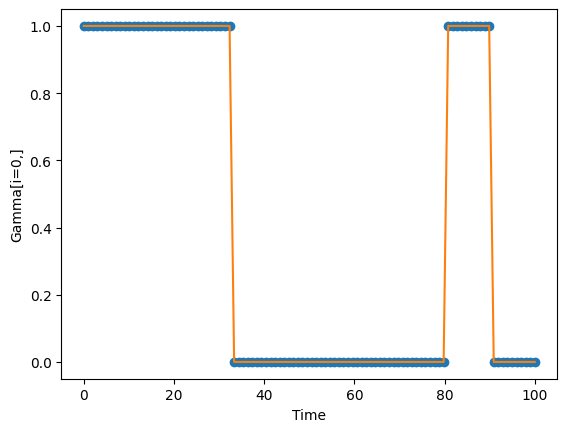

In [178]:
plt.plot(np.linspace(0,100,100), gamma[0,], 'o')
plt.plot(np.linspace(0,100,100), gamma[0,], '-')

# add labels and legend
plt.xlabel('Time')
plt.ylabel('Gamma[i=0,]')

# show plot
plt.show()

In [ ]:
# Element-wise multiplication of alpha and beta
gamma = alphas_opt * betas_opt

# Column-wise normalization of gamma
col_sums = np.sum(gamma, axis=0, keepdims=True)
gamma = gamma / col_sums[0,0]

print(gamma)

In [ ]:
n=2
T=len(x)
xi = np.zeros((n, n, T-1))

for t in range(T-1):
    for i in range(n):
        for j in range(n):
            xi[i, j, t] = alphas_opt[i, t] * A[i, j] * b[j, t+1] * betas_opt[j, t+1]

    xi[:, :, t] /= xi[:, :, t].sum()
